In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

##Import any other packages you may need here

# Exploratory Data Analisys

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)  ok
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases, ok
    * number of non-pneumonia cases, ok 
* The distribution of other diseases that are comorbid with pneumonia, ok
* Number of disease per patient ok
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## Aditional functions

I wrote some auxiliary fuctions to perform the EDA

In [3]:
# function to get unique values
def unique(list1):
    # intilize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def splitClasses(string):
    return string.split('|')

def getAllDifferentClasses(dataframe, column):
    labels = all_xray_df[column].unique()
    anidada = [splitClasses(cs) for cs in labels]
    labels = [l for lista in anidada for l in lista]
    return unique(labels)

def getCounts(df, column, labels):
    col = df[column]
    diccionario  = {l:0 for l in labels}
    for element in col:
        lsplit = splitClasses(element)
        #print(lsplit)
        for l_individual in lsplit:
            #print(diccionario[l_individual])
            diccionario[l_individual] += 1
    return diccionario
        
def plotCounts(counts_dict, graphWidth, name='Counts'):
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    plt.xticks(rotation='vertical')
    plt.title(name)
    plt.bar(*zip(*counts_dict.items()), color=['red', 'green', 'blue', 'cyan', 'black'])
    plt.show()
    
def countPairs(df, column, la, lb):
    col = df[column]
    suma = 0
    for element in col:
        lsplit = splitClasses(element)
        if la in lsplit and lb in lsplit:
            suma += 1
    return suma


def coOcurrencia(dataframe, column):
    #labelsmix = dataframe[column].unique()
    labels = getAllDifferentClasses(dataframe, column)
    n_labels = len(labels)
    matrix_coo = np.zeros((n_labels,n_labels))
    
    for i, la in enumerate(labels):
        max_count = 0
        normalize = False;
        for j, lb in enumerate(labels):
            #search pair (la, lb)
            count = countPairs(dataframe, 'Finding Labels', la, lb)
            matrix_coo[i][j] = count
            if count > max_count:
                max_count = count
                normalize = True
        if normalize:
            matrix_coo[i] = matrix_coo[i] * (1/max_count)
    return labels, matrix_coo


def plotCorrelationMatrix(labels, matrix, graphWidth, title='Correlation Matrix for'):
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(matrix, fignum = 1)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(title, fontsize=15)
    plt.show()

In [4]:
## EDA
# Veamos que hay en el directorio que nos proveen
print(os.listdir('/data'))

['FAQ_CHESTXRAY.pdf', 'ARXIV_V5_CHESTXRAY.pdf', 'images_009', 'images_011', 'images_003', 'images_004', 'README_CHESTXRAY.pdf', 'images_012', 'images_007', 'images_005', 'train_val_list.txt', 'BBox_List_2017.csv', 'images_001', 'images_008', 'LOG_CHESTXRAY.pdf', 'images_006', 'test_list.txt', 'images_002', 'images_010', 'Data_Entry_2017.csv']


## Working with NIH Data



In [10]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

nRow, nCol = all_xray_df.shape
print(f'There are {nRow} rows and {nCol} columns')

all_xray_df.sample(10)

There are 112120 rows and 12 columns


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
74861,00018366_021.png,No Finding,21,18366,64,F,PA,2386,2991,0.143,0.143,NaN
23686,00006271_017.png,No Finding,17,6271,40,M,AP,2500,2048,0.171,0.171,NaN
83426,00020482_012.png,Consolidation|Infiltration,12,20482,29,F,AP,3056,2544,0.139,0.139,NaN
57050,00014174_004.png,No Finding,4,14174,52,F,AP,2500,2048,0.168,0.168,NaN
45023,00011565_000.png,No Finding,0,11565,63,F,PA,2874,2991,0.143,0.143,NaN
111651,00030573_014.png,No Finding,14,30573,26,M,AP,3056,2544,0.139,0.139,NaN
52793,00013310_026.png,Infiltration,26,13310,58,M,AP,2500,2048,0.168,0.168,NaN
80643,00019805_002.png,Mass,2,19805,29,M,PA,2992,2991,0.143,0.143,NaN
10508,00002720_018.png,Atelectasis,18,2720,62,F,AP,2500,2048,0.171,0.171,NaN
53174,00013424_004.png,Effusion,4,13424,57,M,AP,2500,2048,0.168,0.168,NaN


In [13]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
81345,00019980_000.png,Infiltration,0,19980,40,F,PA,2550,2913,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100939,00026810_042.png,Consolidation|Infiltration|Mass,42,26810,55,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
22062,00005840_000.png,No Finding,0,5840,48,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Average age:  46.90146271851587


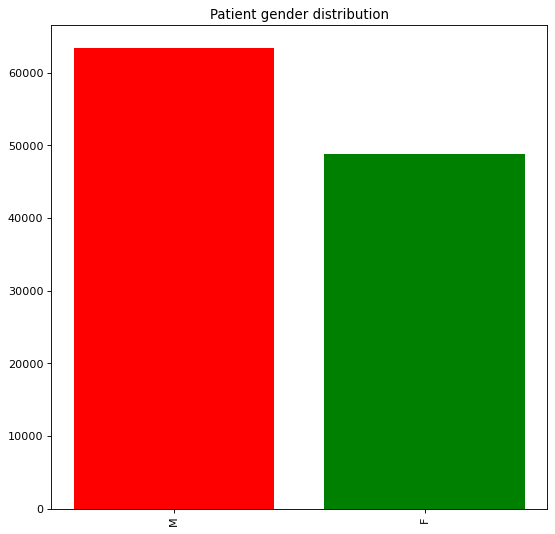

In [14]:
# Get average Age
ages = all_xray_df['Patient Age']
average_age = np.average(ages)
print("Average age: ", average_age)

# Plot gender distribution
column = 'Patient Gender'
labels = getAllDifferentClasses(all_xray_df, column)
dict_counts = getCounts(all_xray_df, column, labels)
plotCounts(dict_counts, 8, name = "Patient gender distribution")

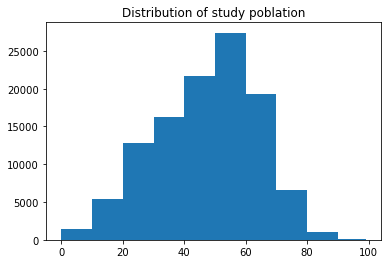

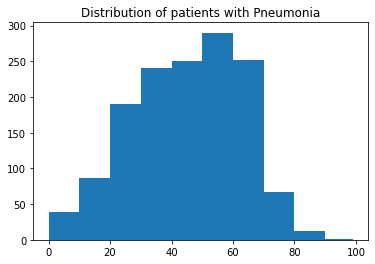

In [25]:
with_pneumonia = np.array(all_xray_df['Pneumonia'])
indexes = np.where(with_pneumonia==1)[0]
#print(indexes)
ages_pneu = ages[list(indexes)]

plt.hist(ages, bins=[0,10,20,30,40,50,60,70,80,90,99])
plt.title('Distribution of study poblation')
plt.show() 

plt.hist(ages_pneu, bins=[0,10,20,30,40,50,60,70,80,90,99])
plt.title('Distribution of patients with Pneumonia')
plt.show() 


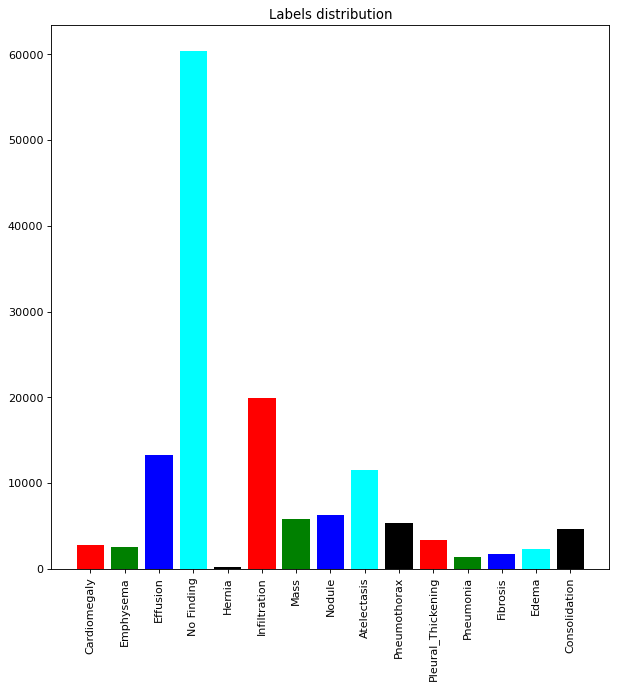

In [26]:
# Plot disease labels distribution

column = 'Finding Labels'
labels = getAllDifferentClasses(all_xray_df, column)
dict_counts = getCounts(all_xray_df, column, labels)

plotCounts(dict_counts, 9, name= 'Labels distribution')

Neumonia Cases: 1431
No neumonia Cases: 110689
defaultdict(<function <lambda> at 0x7fb0739d48c0>, {1: 30963, 2: 14306, 4: 1247, 3: 4856, 5: 301, 6: 67, 7: 16, 8: 1, 9: 2})


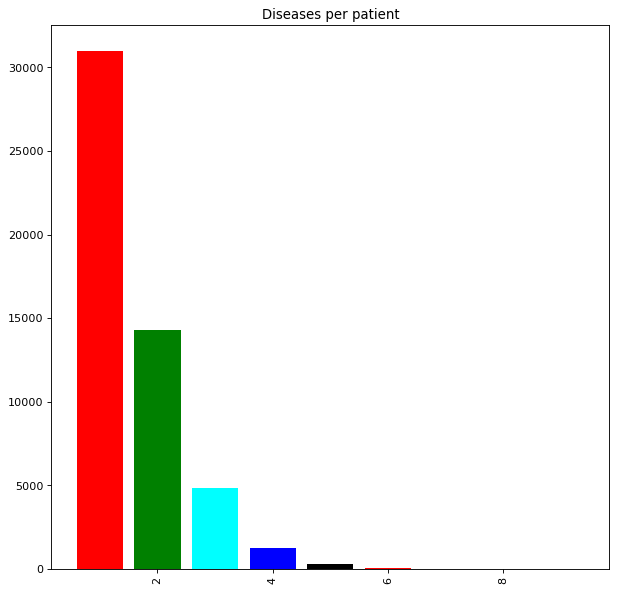

In [27]:
from collections import defaultdict 

print('Neumonia Cases:', dict_counts['Pneumonia'])
print('No neumonia Cases:', nRow - dict_counts['Pneumonia'])

labelsmix = all_xray_df['Finding Labels']
diseases_per_row = [len(element) for element in labelsmix]
diseases_per_patient = defaultdict(lambda: 0)
no_disease = 'No Finding'
for diseases in labelsmix:
    lbls = splitClasses(diseases)
    #print(lbls)
    if no_disease not in lbls:
        diseases_per_patient[len(lbls)] += 1
        
print(diseases_per_patient)
#abcisas = np.arrange

plotCounts(diseases_per_patient, 9, name = 'Diseases per patient')

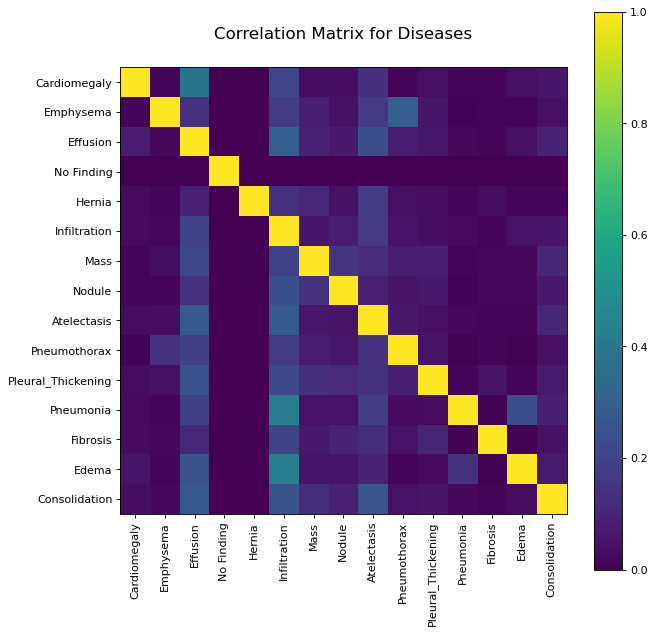

In [28]:
column = 'Finding Labels'
labels, matco = coOcurrencia(all_xray_df, column)

plotCorrelationMatrix(labels, matco, 9, title = 'Correlation Matrix for Diseases')

##  Working with Sample Labels


In [6]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(10)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2753,00013798_000.png,No Finding,0,13798,021Y,F,PA,2364,2916,0.143,0.143
5157,00027464_033.png,No Finding,33,27464,035Y,F,PA,2544,3056,0.139,0.139
3555,00017594_002.png,No Finding,2,17594,036Y,M,PA,2992,2991,0.143,0.143
4331,00021332_000.png,No Finding,0,21332,068Y,M,PA,3056,2496,0.139,0.139
1738,00009161_000.png,No Finding,0,9161,048Y,F,PA,2500,2048,0.168,0.168
539,00002765_003.png,No Finding,3,2765,047Y,F,PA,2048,2500,0.168,0.168
443,00002359_018.png,No Finding,18,2359,070Y,M,AP,2048,2500,0.168,0.168
5135,00027320_014.png,Infiltration,14,27320,052Y,M,PA,2992,2991,0.143,0.143
3324,00016426_000.png,No Finding,0,16426,032Y,M,PA,2614,2645,0.143,0.143
4915,00025888_001.png,No Finding,1,25888,033Y,F,PA,2992,2991,0.143,0.143


### Pixel level information

In [7]:
# Again we will see the data
print(os.listdir('./'))

['test5.dcm', 'my_model.json', 'FDA_Submission_Template.md', 'Build and train model.ipynb', 'xray_class_my_model.best.hdf5', '.ipynb_checkpoints', 'test4.dcm', 'sample_labels.csv', 'Inference.ipynb', 'test6.dcm', 'test2.dcm', 'test3.dcm', 'EDA.ipynb', 'test1.dcm']


In [11]:
import pydicom

# Read the DICOM's pixel_array attribute into a dataframe using the pydicom.dcmread function
dcm = pydicom.dcmread('test1.dcm')

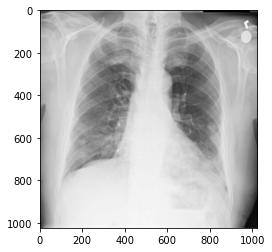

In [13]:
# visualize the image
plt.imshow(dcm.pixel_array,cmap='gray')

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

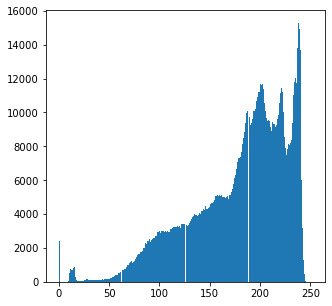

In [17]:
# Draw histograms
values = dcm.pixel_array.ravel()

plt.figure(figsize=(5,5))
plt.hist(values, bins = 256)

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

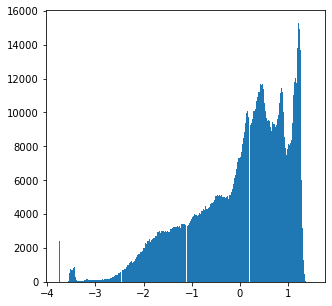

In [18]:
# Find the mean and std dev intensity values of the image, and standerdize it

mean_intensity = np.mean(dcm.pixel_array)
mean_intensity

std_intensity = np.std(dcm.pixel_array)
std_intensity

new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity

plt.figure(figsize=(5,5))
plt.hist(new_img.ravel(), bins = 256)

### Conclusions

First we observe that the data is balanced in terms of patient genre. However classes as imbalanced in terms of findings, the majoritary class of 'no findings' can be more than ten times the number of examples from the pneumonia class. Therefore, we have to some techniques for adrressing the umbalanced problem, for example, at training stage, a balanced sub-dataset can be made using subsampling. The correlation matrix shows that pneumonia is correlated with infiltration, this information could be used to improve the detection of pneumonia if infiltration is present. Finally, with respect to pixel information, histograms can vary between images, a histogram equalization can be made, however, this preprocessing must be validated by the accuracy reached.
